In [1]:
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

# Create something to plot


The typical usage pattern of histograms in HEP is to create (possibly multidimensional) emperical PDFs via filling pre-defined histograms with the results of Monte-Carlo sampling on high-dimensional phase spaces. There are typically multiple such PDFs, partitioned by the type of physical process which the PDF describes. Here we make some simple PDFs on a single variable x, for a signal sample described by a gaussian distribution and two background samples constructed from exponential distributions. Each emperical PDF comes with an overall weight parameter that scales it to the appropriate expected events in real data based on the expected rate of production and the data collection condititions.

Lastly, create some pseudodata drawing Poisson-distributed random values from the sum of all processes.

In [3]:
x_signal = np.random.normal(loc=6, scale=1, size=100)
weight_signal = 0.3

x_bkg1 = np.random.exponential(scale=3, size=2000)
weight_bkg1 = 0.2

x_bkg2 = np.random.exponential(scale=1, size=1000)
weight_bkg2 = 0.1

bin_edges = np.linspace(0., 15., 16)

pdf_signal = np.histogram(x_signal, bins=bin_edges)[0]*weight_signal
pdf_bkg1   = np.histogram(x_bkg1,   bins=bin_edges)[0]*weight_bkg1
pdf_bkg2   = np.histogram(x_bkg2,   bins=bin_edges)[0]*weight_bkg2

# Usually sumw2 would be part of the histogram filling package
sumw2_bkg1 = pdf_bkg1*weight_bkg1
sumw2_bkg2 = pdf_bkg2*weight_bkg2
sumw2_sig = pdf_signal*weight_signal


sum_bkg = pdf_bkg1 + pdf_bkg2
sumw2_bkg = sumw2_bkg1 + sumw2_bkg2

observed_pdf = np.random.poisson(sum_bkg + pdf_signal)

# Styling


Generally speaking, it's good practice to separate the style definition from the plot contents. In fact, matplotlib has a versatile style sheet facility. Let's define some styles now for use in the rest of the notebook.



In [4]:
fig_style = {
    'figsize': (5, 5),
}

ratio_fig_style = {
    'figsize': (5, 5),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

stack_style = {
    'edgecolor': (0, 0, 0, 0.5),
}

hatch_style = {
    'facecolor': 'none',
    'edgecolor': (0, 0, 0, 0.5),
    'linewidth': 0,
    'hatch': '///',
}

errorbar_style = {
    'linestyle': 'none',
    'marker': '.',
    'elinewidth': 1,
    'capsize': 1,
    'color': 'k',
}

shaded_style = {
    'facecolor': (0,0,0,0.3),
    'linewidth': 0
}

# Step plot with uncertainty¶


This plot type is typically used for comparing several distributions as a function of the same variable. In this case, the uncertainty is due to the finite statistics of the Monte-Carlo generation of the PDFs, and is approximated by sqrt(sumw2) where sumw2 is the sum of squared weights. For the observation, this is simplified to sqrt(n). When the counts are small (n < ~10), a more exact procedure (with regards to coverage) is to use Garwood intervals:

    err_lo = scipy.stats.chi2.ppf((1 - coverage)/2, 2*counts)/2.
    err_hi = scipy.stats.chi2.ppf((1 + coverage)/2, 2*(counts + 1))/2.

<IPython.core.display.Javascript object>


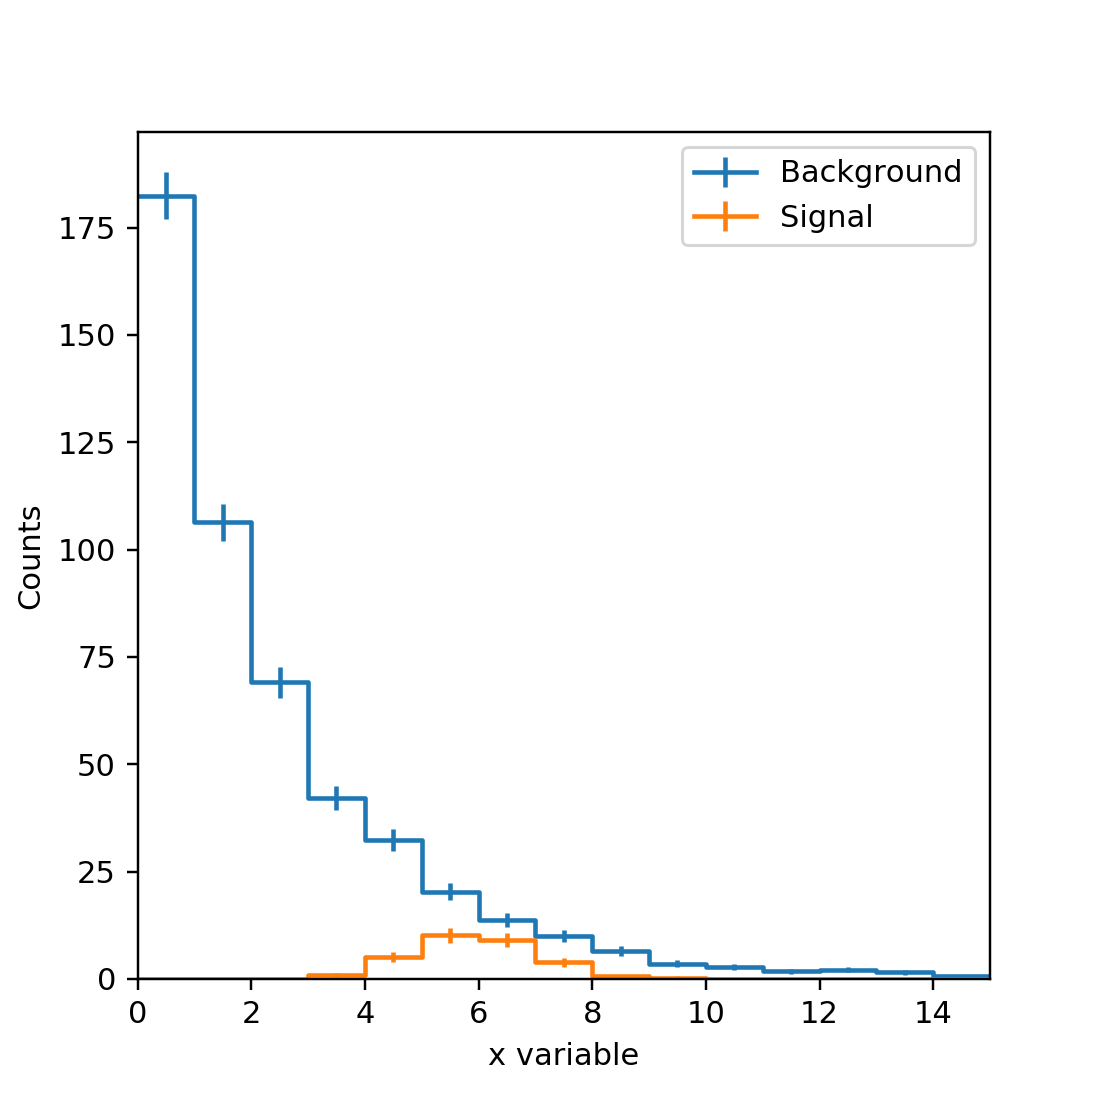

Text(0, 0.5, 'Counts')

In [5]:
fig, ax = plt.subplots(**fig_style)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

# To draw both the vertical error bar as well as a stairstep through
# the bin content we have to make two separate draw calls.  
line1, = ax.step(x=bin_edges,
                 # Depending on the 'where' option ('pre' or 'post'), the last bin 
                 # needs be concatenated on one side, so that the edge bin is drawn
                 y=np.hstack([sum_bkg, sum_bkg[-1]]),
                 where='post'
                )
err1 = ax.errorbar(x=bin_centers,
                   y=sum_bkg,
                   yerr=np.sqrt(sumw2_bkg),
                   # By default, a line connecting the errorbars is drawn, turn it off
                   linestyle='none',
                   # Grab the last used color, so that the objects share the same color
                   color=line1.get_color()
                  )

line2, = ax.step(x=bin_edges, y=np.hstack([pdf_signal, pdf_signal[-1]]), where='post')
err2 = ax.errorbar(x=bin_centers, y=pdf_signal, yerr=np.sqrt(sumw2_sig),
            linestyle='none', color=line2.get_color()
           )

# matplotlib defaults to having a margin around the visible plots, this removes it
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)

# A tuple can be passed to plt.legend to group two items together
# (and hence overlay their legend marker styles)
ax.legend([(line1, err1), (line2, err2)], ['Background', 'Signal'])

ax.set_xlabel('x variable')
ax.set_ylabel('Counts')

# Stack plot with ratio¶


This plot type is used to compare the sum of expected contributions to the observation.



<IPython.core.display.Javascript object>


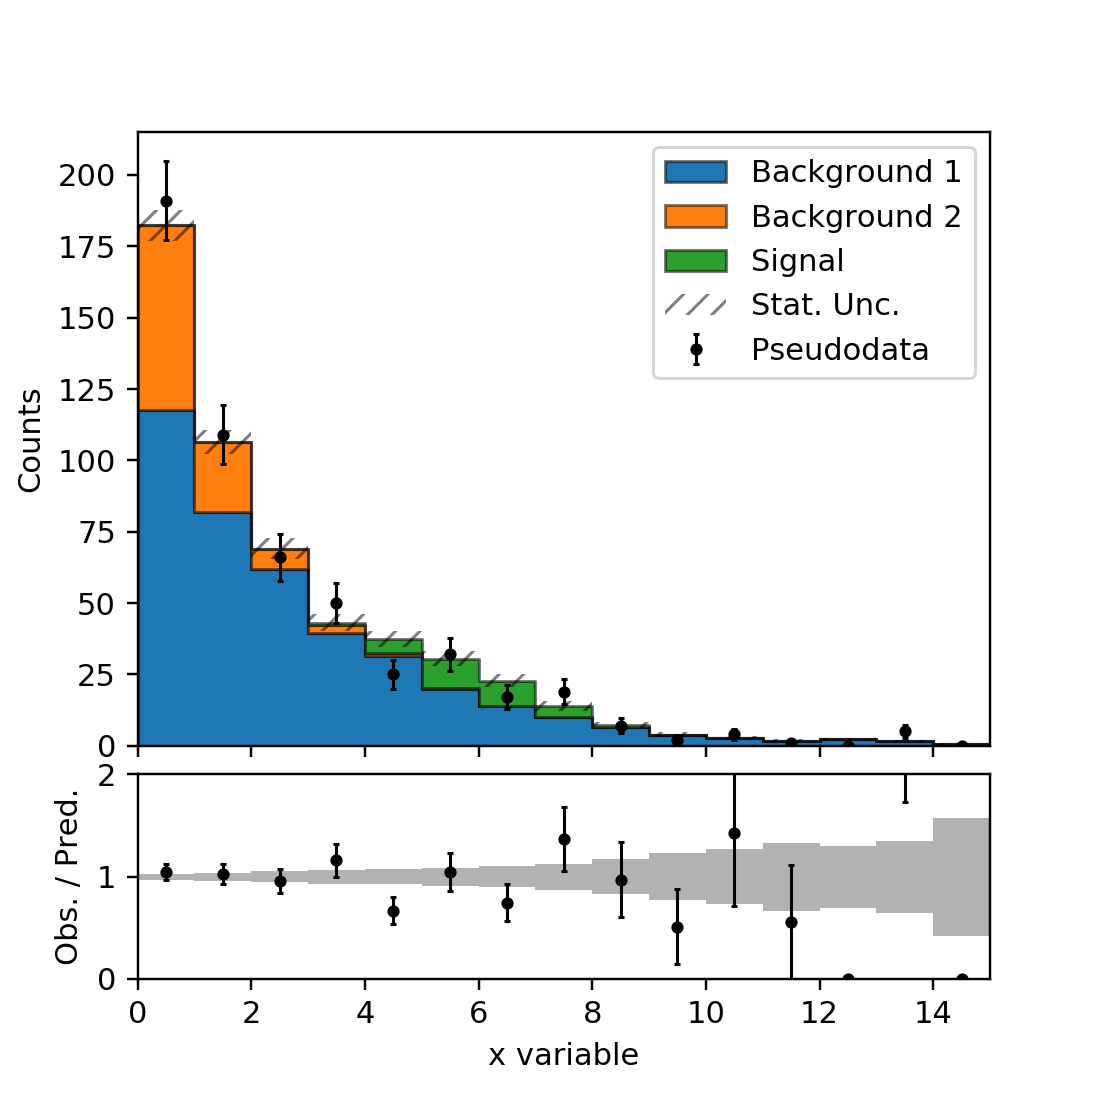

In [6]:
fig, (ax, rax) = plt.subplots(2, 1, sharex=True, **ratio_fig_style)
fig.subplots_adjust(hspace=.07)  # this controls the margin between the two axes

# Stack up the various contributions
labels = ['Background 1', 'Background 2', 'Signal']
sumw_stack = np.vstack([pdf_bkg1, pdf_bkg2, pdf_signal])
# depending on step option ('pre' or 'post'), the last bin
# needs be concatenated on one side, so that the edge bin is drawn
sumw_stack = np.hstack([sumw_stack, sumw_stack[:,-1:]])
ax.stackplot(bin_edges, sumw_stack, labels=labels, step='post', **stack_style)

# Overlay an uncertainty hatch
sumw_total = sumw_stack.sum(axis=0)
unc = np.sqrt(sumw2_sig + sumw2_bkg)
unc = np.hstack([unc, unc[-1]])
ax.fill_between(x=bin_edges, y1=sumw_total - unc, y2=sumw_total + unc,
                label='Stat. Unc.', step='post', **hatch_style
               )

# Draw the observation
ax.errorbar(x=bin_centers, y=observed_pdf, yerr=np.sqrt(observed_pdf),
            label='Pseudodata', **errorbar_style
            )

ax.set_ylim(0, None)
ax.set_ylabel('Counts')
ax.legend()

# Draw some sort of ratio, keeping the two uncertainty sources
# separate rather than combining (as per tradition)
rax.fill_between(x=bin_edges, y1=1 - unc/sumw_total, y2=1 + unc/sumw_total, step='post', **shaded_style)
sumw_total = sumw_total[:-1]  # Take away that copy of the last bin
rax.errorbar(x=bin_centers, y=observed_pdf/sumw_total, yerr=np.sqrt(observed_pdf)/sumw_total, **errorbar_style)

rax.set_ylim(0, 2)
rax.set_ylabel('Obs. / Pred.')
# setting the x label on the stack pad clashes with the ratio axes frame
rax.set_xlabel('x variable')
# we have to autoscale in the ratio axis after drawing all items
rax.autoscale(axis='x', tight=True)

# Using plt.hist


matplotlib supports direct histogram function plt.hist, although it expects an array of values to be input. One can use it to plot pre-binned data by supplying a single entry with an asociated weight per bin.



<IPython.core.display.Javascript object>


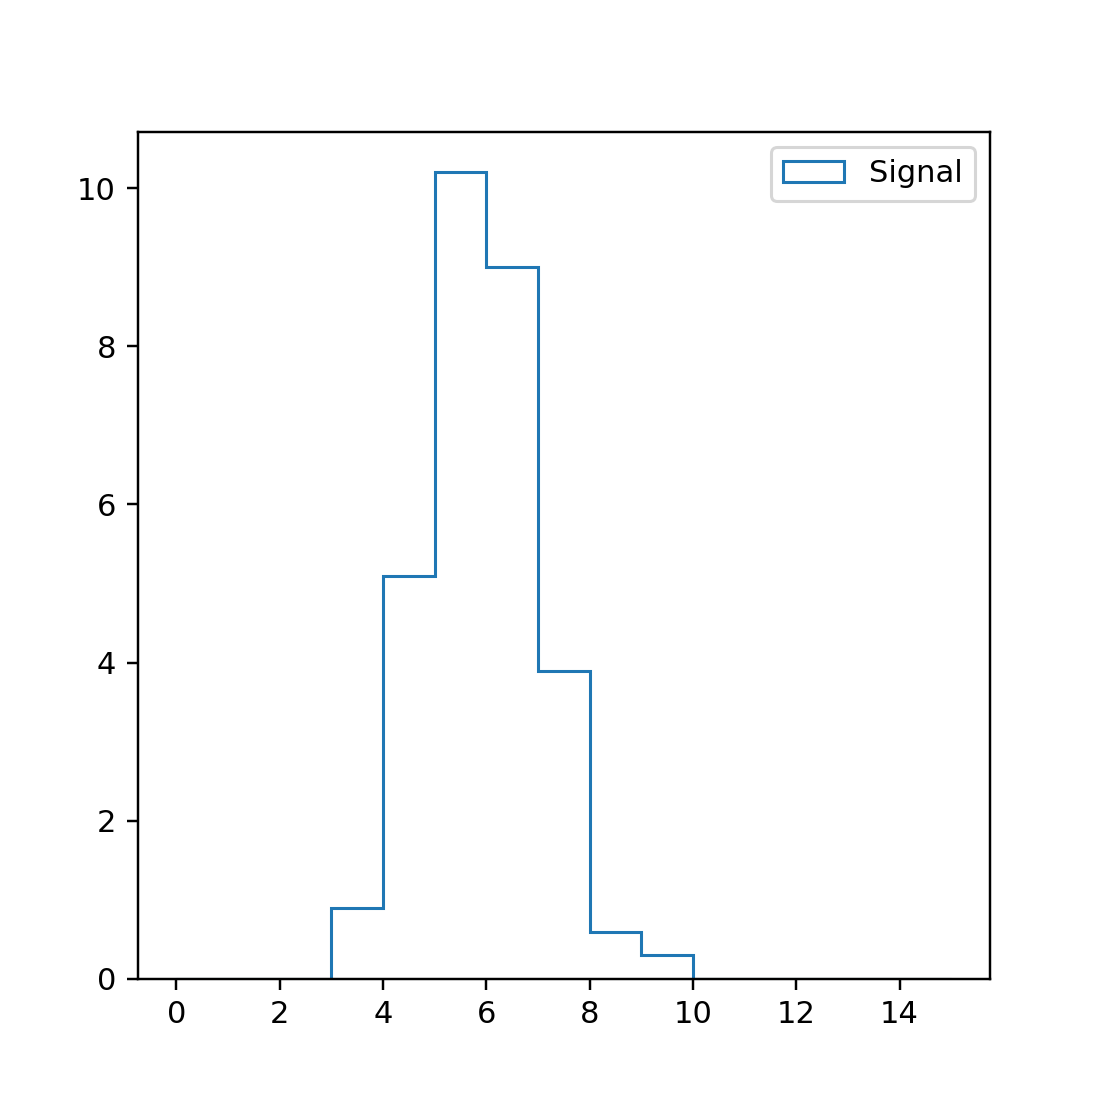

In [7]:
ig, ax = plt.subplots(**fig_style)

# Create histogram of signal and background pdfs
pdf_contents, pdf_bins = np.histogram(x_signal, bins=bin_edges)

ax.hist(pdf_bins[:-1],
         bins=pdf_bins,
         weights=pdf_contents*weight_signal,
         histtype='step',
         label='Signal',
        )
ax.legend(loc='best')

# 2D Colormap

This plot type allows the visualizationg of joint probability densities. We'll need some new data for this, so let's make up a gaussian sum mixture with some correlation.

In [8]:
xy = np.random.multivariate_normal(mean=[2, 2], cov=[[0.1, 0.2], [0.2, 0.8]], size=1000)
xedges = np.linspace(0, 4, 11)
yedges = np.linspace(0, 4, 21)
pdf_xy, *_ = np.histogram2d(x=xy[:,0], y=xy[:,1], bins=(xedges, yedges))

<IPython.core.display.Javascript object>


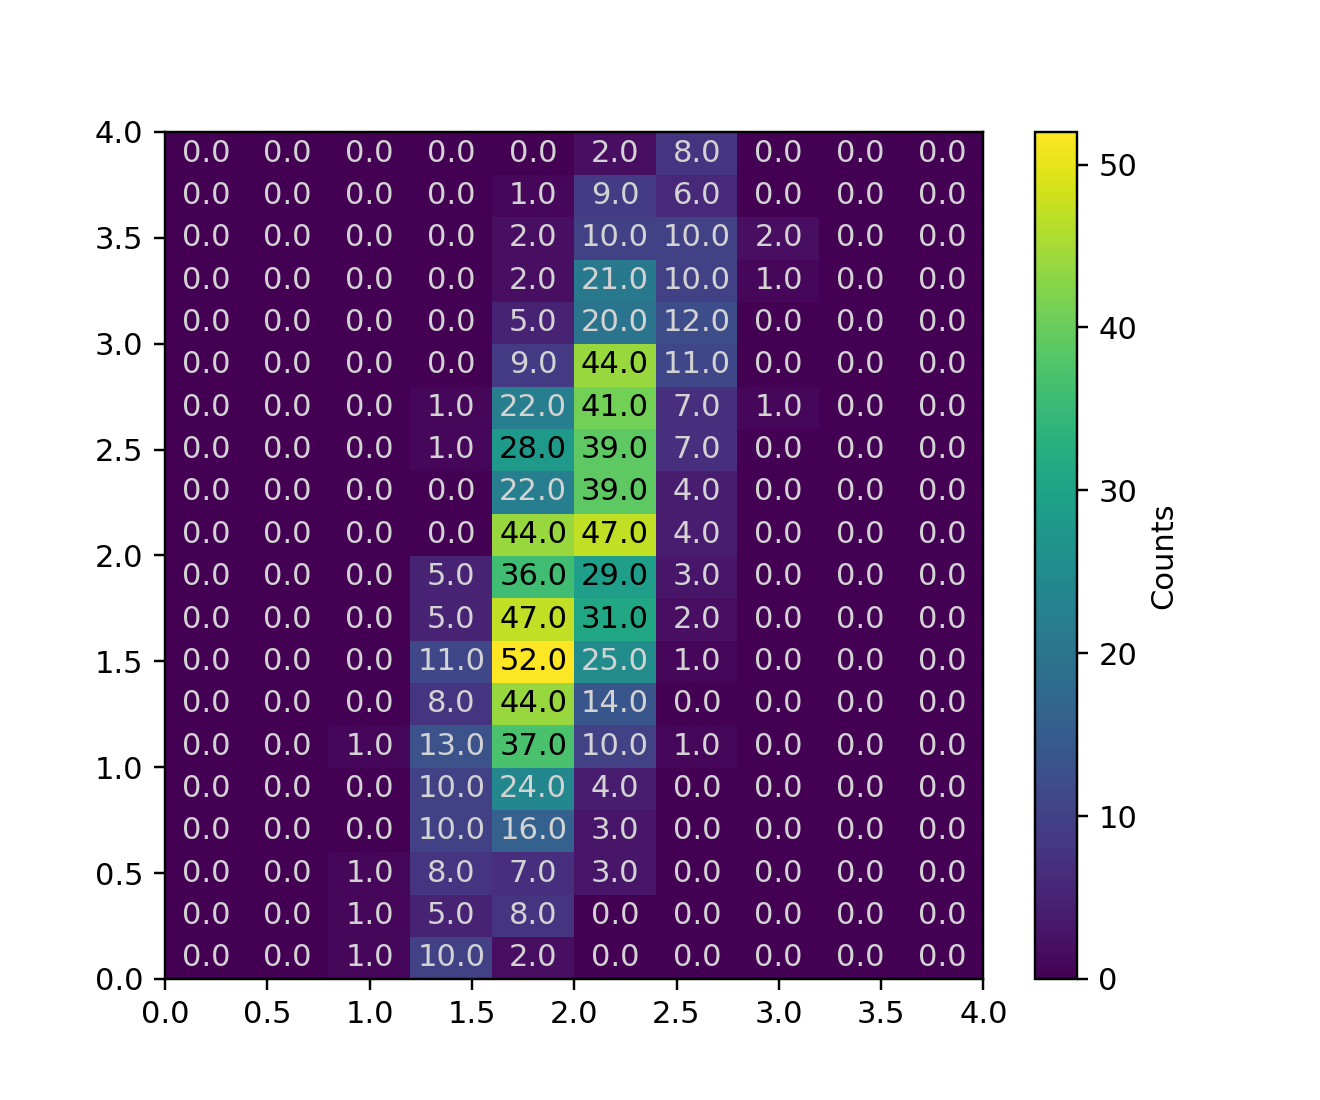

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))  # need some extra room for the colorbar

xmesh, ymesh = np.meshgrid(xedges, yedges)
# pcolormesh assumes the array is (y,x) ordered!
pc = ax.pcolormesh(xmesh, ymesh, pdf_xy.T)
fig.colorbar(pc, ax=ax, label='Counts')

# text annotation appears to be a manual operation
# c.f. https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
for ix, xc in enumerate((xedges[:-1] + xedges[1:])/2):
    for iy, yc in enumerate((yedges[:-1] + yedges[1:])/2):
        color = 'black' if pc.norm(pdf_xy[ix, iy]) > 0.5 else 'lightgrey' 
        ax.text(xc, yc, pdf_xy[ix, iy], ha='center', va='center', color=color)